In [1]:
import numpy as np
import scipy.optimize as scopt
import numdifftools as ndt
from scipy.stats import multivariate_normal
import emcee
import ptemcee
import multiprocessing as mp

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from corner import corner

from model import LinearModel, ExponentialModel
from mcmc_convergence import rhat

%matplotlib inline
plt.style.use("default")
np.random.seed(2023)

# Define the model

The linear model has a form
\begin{equation}
    f(\theta; t) = \sum_{n=0}^{N-1} \theta_n t^n.
\end{equation}

In [2]:
t = np.logspace(-1, 0, 3)
data = np.random.uniform(0.0, 1.0, len((t)))
data_error = data
model = LinearModel(2, t, data, data_error)

In [3]:
# Train the model
opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
bestfit = opt.x
print(opt)

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.414e-01  5.148e-01 -8.168e-02]
           x: [ 3.377e-01  2.984e-01]
        cost: 0.14583739481506852
         jac: [[-3.106e+00 -3.106e-01]
               [-1.123e+00 -3.551e-01]
               [-1.701e+00 -1.701e+00]]
        grad: [ 1.500e-09  8.351e-10]
  optimality: 1.5002624241650547e-09
 active_mask: [0 0]
        nfev: 6
        njev: None


In [4]:
# Generate data to plot the cost surface and model manifold
params_list = np.linspace(-3, 3, 100)
P0, P1 = np.meshgrid(params_list, params_list)
COST = np.zeros_like(P0)
PREDS = np.zeros((*P0.shape, model.M))
for ii in range(len(params_list)):
    for jj in range(len(params_list)):
        params = np.array([P0[ii, jj], P1[ii, jj]])
        PREDS[ii, jj] = model.predict(params)
        COST[ii, jj] = model.cost(params)

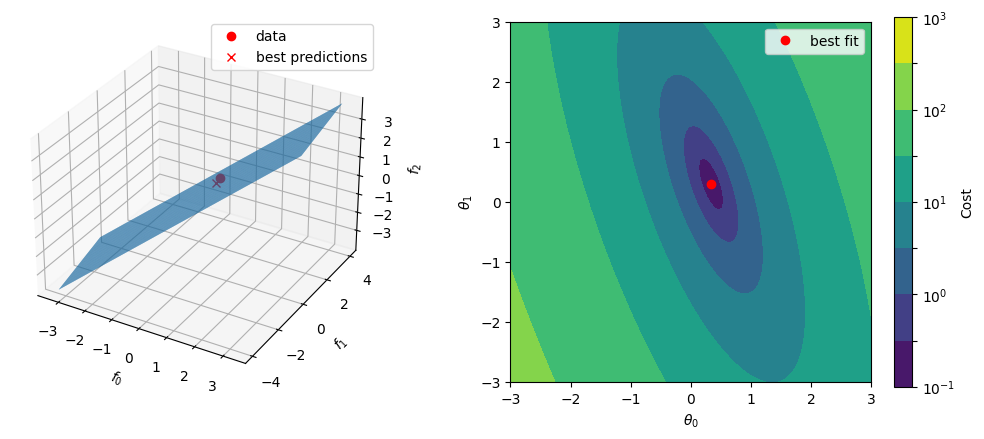

In [5]:
# Plot model manifold and cost surface
plt.figure(figsize=(6.4 * 2, 4.8))

# Plot model manifold
ax0 = plt.subplot(121, projection="3d")
ax0.plot_trisurf(
    PREDS[:, :, 0].flatten(),
    PREDS[:, :, 1].flatten(),
    PREDS[:, :, 1].flatten(),
    antialiased=True,
)
ax0.plot(*model.data, "ro", label="data")
ax0.plot(*(model.predict(bestfit)), "rx", label="best predictions")
ax0.set_xlabel(r"$f_0$")
ax0.set_ylabel(r"$f_1$")
ax0.set_zlabel(r"$f_2$")
ax0.legend()

# Plot cost surface
ax1 = plt.subplot(122)
im = ax1.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 9)
)
clb = plt.colorbar(im, ax=ax1)
ax1.plot(*bestfit, "ro", label="best fit")

ax1.set_xlabel(r"$\theta_0$")
ax1.set_ylabel(r"$\theta_1$")
clb.set_label("Cost")
ax1.set_aspect(1)
ax1.legend()
plt.show()

# Uncertainty propagation via Monte Carlo

With Monte Carlo method, we generate an ensemble of artificial data that approximate the actual distribution of the data.
In this demonstration, we can do this by using the data and the error bars to generate some random noise.
Then, we will train the model to fit each of the data sample.

In [6]:
# Generate an artificial distribution of the data
data_ensemble = np.random.multivariate_normal(
    mean=model.data, cov=np.diag(model.data_error**2), size=1000
)

In [7]:
# Parameter ensemble
param_ensemble = np.zeros((len(data_ensemble), model.N))
for ii, dens in enumerate(data_ensemble):
    model.data = dens
    opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
    param_ensemble[ii] = opt.x

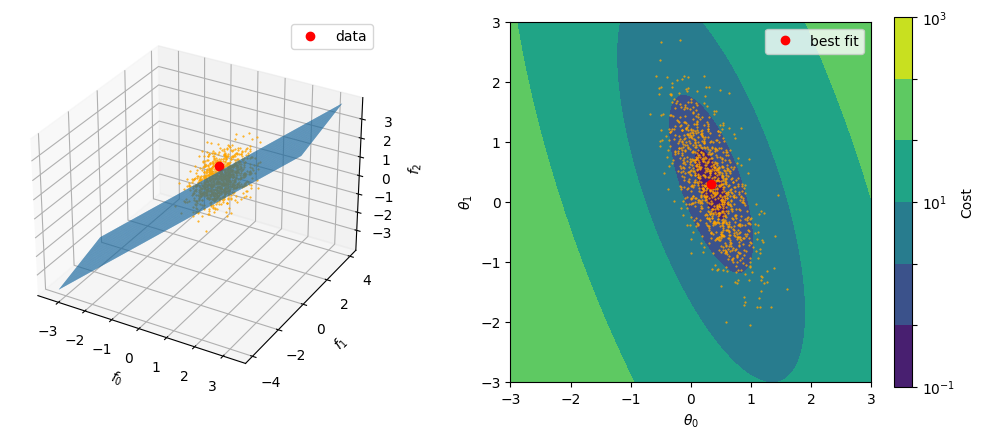

In [8]:
# Plot model manifold and cost surface
plt.figure(figsize=(6.4 * 2, 4.8))

# Plot model manifold
ax0 = plt.subplot(121, projection="3d")
ax0.plot_trisurf(
    PREDS[:, :, 0].flatten(),
    PREDS[:, :, 1].flatten(),
    PREDS[:, :, 1].flatten(),
    antialiased=True,
)
ax0.plot(*(data_ensemble.T), ".", c="orange", ms=1)
ax0.plot(*model.data, "ro", label="data")
ax0.set_xlabel(r"$f_0$")
ax0.set_ylabel(r"$f_1$")
ax0.set_zlabel(r"$f_2$")
ax0.legend()

# Plot cost surface
ax1 = plt.subplot(122)
im = ax1.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 7)
)
clb = plt.colorbar(im, ax=ax1)
plt.plot(*(param_ensemble.T), ".", color="orange", ms=1)
ax1.plot(*bestfit, "ro", label="best fit")

ax1.set_xlabel(r"$\theta_0$")
ax1.set_ylabel(r"$\theta_1$")
clb.set_label("Cost")
ax1.set_aspect(1)
ax1.legend()
plt.show()

# Fisher information

The Fisher information matrix (FIM) gives a local approximation of the parameter uncertainty.
The eigenvalues and eigenvectors of the FIM describe the local shape of the cost surface.
The inverse of the FIM also approximates the covariance matrix of the parameters.

In [9]:
# Compute FIM
Jfun = ndt.Jacobian(model.residual)
J = Jfun(bestfit)
I = J.T @ J  # Note that the error bars are included in the Jacobian already
eigvals, eigvecs = np.linalg.eigh(I)
print(eigvals)

[ 1.62677837 15.28606075]


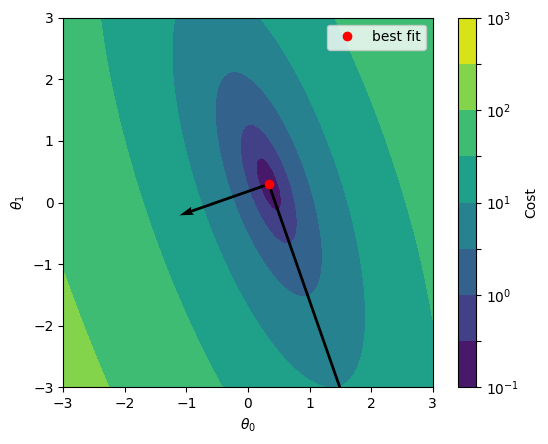

In [10]:
# Plot the eigenvectors of the FIM on top of the cost surface. The vectors are scaled
# by 1/sqrt(lambda).
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 9)
)
clb = plt.colorbar(im)
plt.plot(*bestfit, "ro", label="best fit")

for lam, v in zip(eigvals, eigvecs.T):
    scale = np.sqrt(lam)
    plt.quiver(*bestfit, *v, scale=scale)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.gca().set_aspect(1)
plt.legend()
plt.show()

## Comparison to Monte Carlo

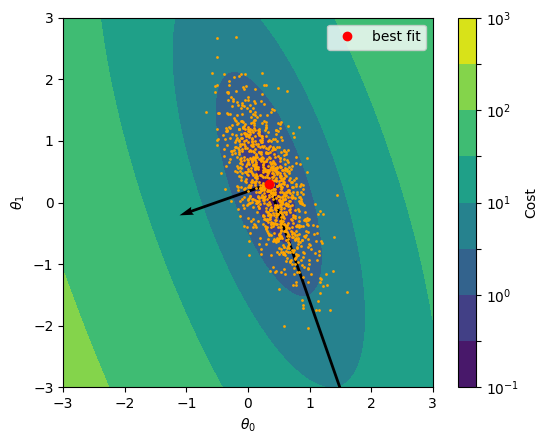

In [11]:
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 9)
)
clb = plt.colorbar(im)

plt.plot(*(param_ensemble.T), ".", color="orange", ms=2)
plt.plot(*bestfit, "ro", label="best fit")

for lam, v in zip(eigvals, eigvecs.T):
    scale = np.sqrt(lam)
    plt.quiver(*bestfit, *v, scale=scale)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.gca().set_aspect(1)
plt.legend()
plt.show()

In [12]:
# Compare the covariance of parameter ensemble with the FIM
print("Covariance of parameter ensemble:")
print(np.cov(param_ensemble.T))

print("Covariance from the FIM")
cov_fim = np.linalg.pinv(I)
print(cov_fim)

Covariance of parameter ensemble:
[[ 0.13204892 -0.1823068 ]
 [-0.1823068   0.56491159]]
Covariance from the FIM
[[ 0.12524133 -0.17111759]
 [-0.17111759  0.55488964]]


# MCMC

The posterior probability of the parameters given the data is given by
\begin{equation}
    P(\theta | d) = \frac{L(\theta | d) \times \pi(\theta)}{P(d)},
\end{equation}
where $L(\theta|d)$ is the likelihood of the model, $\pi(\theta)$ is the prior distribution of the parameters, and $P(d)$ is called the evidence.
The nice thing of MCMC is that it only needs the relative value of the posterior, up to some multiplicative factor, i.e., we don't need the normalization factor.

In [13]:
# Define the posterior
def loglikelihood(x):
    """Log of the likelihood function, up to some multiplicative constant."""
    return -model.cost(x)


def logprior(x):
    """Let's use standard normal prior."""
    return multivariate_normal(mean=np.zeros(ndim)).logpdf(x)


def logposterior(x):
    """Log of the posterior distribution, up to some normalization constant."""
    return loglikelihood(x) + logprior(x)

In [14]:
# MCMC
# Instantiate MCMC sampler
nwalkers = 2 * model.N
ndim = model.N
# pool = mp.Pool(nwalkers)  # Multiprocessing pool
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers,
    ndim=ndim,
    log_prob_fn=logposterior,
    # moves=emcee.moves.StretchMove(a=5.0),  # Adjust the moves
    # pool=pool,  # Multiprocessing
)
# Initial positions of the walkers
p0 = np.random.uniform(-5, 5, (nwalkers, ndim))
# Run MCMC
sampler.run_mcmc(p0, 10_000, progress=True)
# pool.close()
print("Acceptance fraction:", sampler.acceptance_fraction)

100%|███████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 881.82it/s]

Acceptance fraction: [0.7164 0.7097 0.7163 0.7136]


Note: Some people might argue that the acceptance fractions that we get are too high.
There is an argument that the expected acceptance fraction for MCMC should be around 23%.
So, if the acceptance fraction is too high (low), we need to adjust the MCMC move, e.g., increasing (decreasing) the step size.

## Analysis

The analysis consists of 3 steps:
1. Determining the burn-in period.
   We don't want the MCMC result to depend on the initial starting point of the walkers.
2. Computing the autocorrelation length.
   Due to the Markov Chain nature, samples from consecutive iterations are not independent to each other.
   However, we want to extract independent samples from MCMC.
   Thus, we need to thin the chain to get independent samples.
3. Assessing convergence.
   The MCMC simulation should be terminated only when the samples have converged to a stationary distribution.
   Otherwise, the MCMC results would be highly dependent on the number of iterations we take.

In [15]:
# Extract chains
chains = sampler.chain

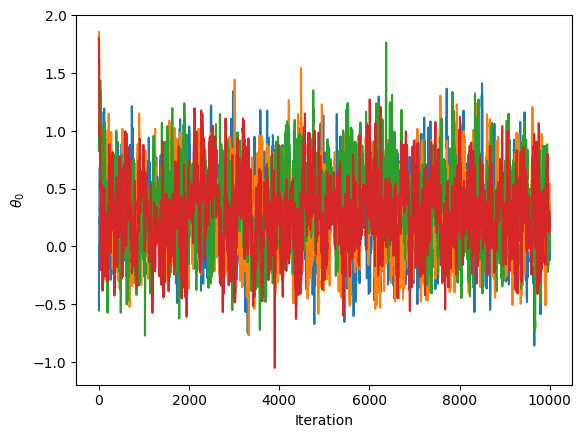

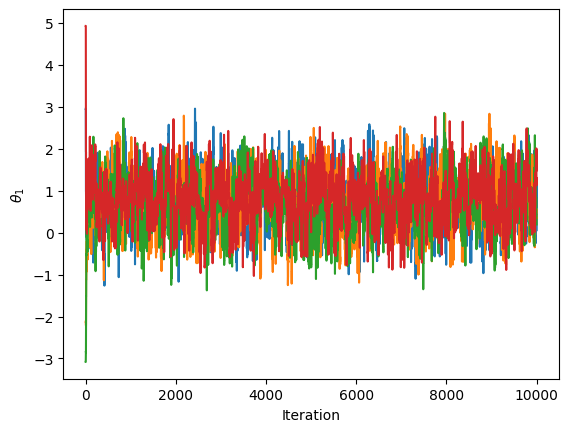

In [16]:
# Burn-in period: We don't want the result to depend on where we start the simulation,
# so we need to discard the first few iterations.
for n in range(ndim):
    plt.figure()
    for w in range(nwalkers):
        plt.plot(chains[w, :, n])
    plt.xlabel("Iteration")
    plt.ylabel(f"$\\theta_{n}$")
plt.show()

In [17]:
# Autocorrelation length: We want the samples to be independent to each other, thus we
# should thin the chains.
# Note: For some reason, the time series needs to be in the first axis.
print("Autocorrelation:", emcee.autocorr.integrated_time(np.swapaxes(chains, 0, 1)))

Autocorrelation: [42.58815378 43.04981166]


In [18]:
# Convergence: We should only stop the MCMC simulation when the independent samples
# converge to a stationary distribution. Here, we will use second order convergence
# assessment method that compares the variance of the samples.
samples = chains[:, 1000::50]
print("PSRF:", rhat(samples))

PSRF: 1.023188797603518


## Plot the samples

The MCMC samples is often presented as a corner plot, which is an array of plots that contain the 2D projection of the samples onto parameter space (below the diagonal) and the marginal distribution of the samples (on the main diagonal).

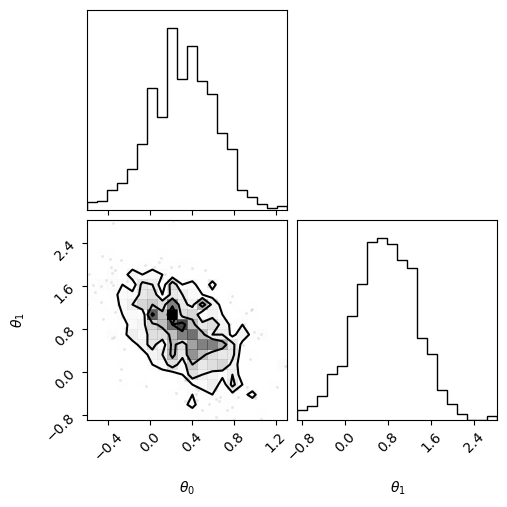

In [19]:
# Present the samples and the distribution as a corner plot.
corner(samples.reshape((-1, ndim)), labels=[r"$\theta_0$", r"$\theta_1$"])
plt.show()

## Comparison with the FIM

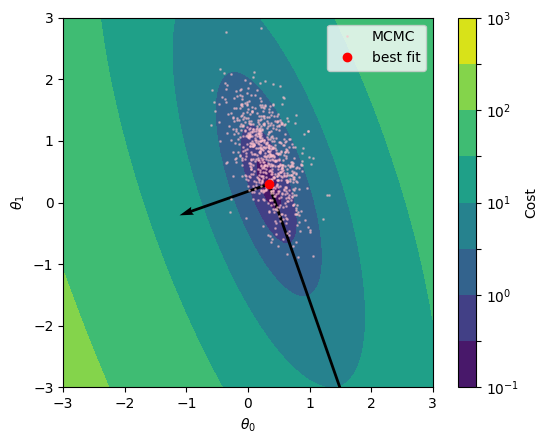

In [20]:
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 9)
)
clb = plt.colorbar(im)
samples_flatten = samples.reshape((-1, ndim))
plt.plot(*(samples_flatten.T), ".", ms=2, c="pink", alpha=0.5, label="MCMC")
plt.plot(*bestfit, "ro", label="best fit")

for lam, v in zip(eigvals, eigvecs.T):
    scale = np.sqrt(lam)
    plt.quiver(*bestfit, *v, scale=scale)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.gca().set_aspect(1)
plt.legend()
plt.show()

In [21]:
# Compare the mean from MCMC and the best fit
mean_MCMC = np.mean(samples_flatten, axis=0)
print("Best fit:", bestfit)
print("MCMC mean:", mean_MCMC)

Best fit: [0.33768691 0.29839712]
MCMC mean: [0.31192589 0.75850227]


In [22]:
# Compare the covariance
print("Covariance from the FIM")
print(cov_fim)

print("Covariance from MCMC samples")
print(np.cov(samples_flatten.T))

Covariance from the FIM
[[ 0.12524133 -0.17111759]
 [-0.17111759  0.55488964]]
Covariance from MCMC samples
[[ 0.0960325  -0.09206831]
 [-0.09206831  0.32208474]]


Note that the parameter distribution from MCMC is not exactly the same as the result we get from the FIM (and also Monte Carlo).
This is the effect of the prior in the Bayesian method.

## Parallel tempering

The idea of parallel tempering in MCMC is to deploy multiple MCMC simulations, each with different sampling temperatures, and exchange the positions of the walkers across the MCMC simulations with some probability of acceptance.
The sampling temperature is used to flatten the likelihood,
\begin{equation}
    P(\theta | d) \propto L(\theta | d)^{1/T} \pi(\theta).
\end{equation}
Higher sampling temperature correspond to flatter likelihood.

Parallel tempering is usually used to speed up convergence, since it allows the walkers to explore wider region in parameter space with the help of MCMC sampling at higher temperatures.

In [23]:
# Instantiate sampler
betas = 1 / np.logspace(0, 1, 3)  # beta = 1/T
ntemps = len(betas)
ptsampler = ptemcee.Sampler(
    nwalkers=nwalkers,
    dim=ndim,
    logl=loglikelihood,
    logp=logprior,
    betas=betas,
)
# Initial position of the walkers
p0 = np.random.uniform(-5, 5, (ntemps, nwalkers, ndim))
# Run MCMC
ptsampler.run_mcmc(p0, 10000, progress=True)
# Retrieve chains
ptchains = ptsampler.chain
print(ptchains.shape)

100%|███████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.56it/s]

(3, 4, 10000, 2)


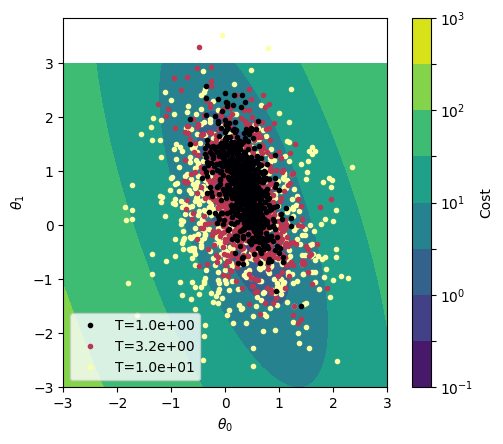

In [24]:
ptsamples = ptchains[:, :, 1000::50]
cmap = mpl.colormaps["inferno"]
colors = cmap(np.linspace(0, 1, ntemps))

plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 3, 9)
)
clb = plt.colorbar(im)
for tidx in range(ntemps):
    ptsamples_flatten = ptsamples[tidx].reshape((-1, ndim))
    plt.plot(
        *(ptsamples_flatten.T),
        ".",
        c=colors[tidx],
        zorder=ntemps - tidx,
        label=f"T={1/betas[tidx]:0.1e}",
    )

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.gca().set_aspect(1)
plt.legend()
plt.show()

The distribution of the samples is wider when sampled at higher sampling temperature.